In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Check that gradients can flow across channel:

In [4]:
channel = CommChannel(size=10, temperature=10, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.18047798 0.25912982 0.34645054 0.21394166]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [5]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [6]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [7]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [8]:
inputs, targets = generate_train_batch()

In [9]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

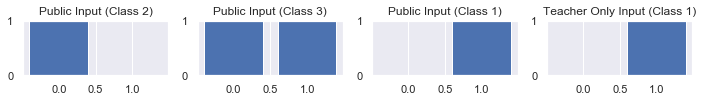

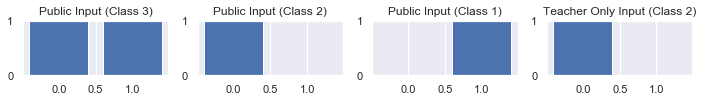

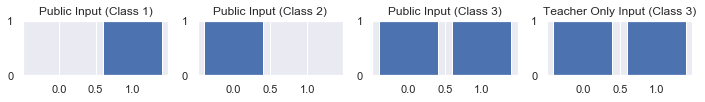

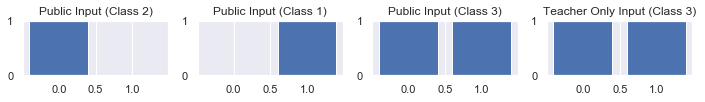

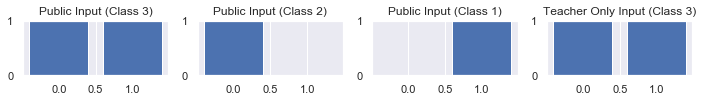

In [10]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [11]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[2, 1, 4, 0],
       [2, 3, 1, 0],
       [1, 3, 4, 0],
       [2, 0, 4, 3],
       [3, 0, 4, 2]], dtype=int64)>

## Create Data-Specific Input Encoder

In [12]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 5

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [13]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
# teacher = experiment.teacher
# student = experiment.student

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student,
                        training=True,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0.5)

    loss = complete_loss_fn(outputs, targets)
#     loss = protocol_diversity_loss(outputs)
#     loss = protocol_entropy(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

print('Mean Loss:', loss.numpy().mean())

print()

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

Instructions for updating:
Use tf.identity instead.
Mean Loss: 3.9693925

agent/dense/kernel:0 teacher grad norm: 1.6125609874725342
agent/dense/bias:0 teacher grad norm: 1.2680222988128662
agent/lstm/kernel:0 teacher grad norm: 3.2664952278137207
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.6952326893806458
agent/lstm/bias:0 teacher grad norm: 2.29992938041687
agent/dense_1/kernel:0 teacher grad norm: 1.5470606088638306
agent/dense_1/bias:0 teacher grad norm: 2.7210919857025146

agent/dense_2/kernel:0 student grad norm: 0.8521512746810913
agent/dense_2/bias:0 student grad norm: 0.7303333878517151
agent/lstm_1/kernel:0 student grad norm: 1.3124239444732666
agent/lstm_1/recurrent_kernel:0 student grad norm: 0.3446507453918457
agent/lstm_1/bias:0 student grad norm: 1.3236489295959473
agent/dense_3/kernel:0 student grad norm: 0.5955989956855774
agent/dense_3/bias:0 student grad norm: 1.6161003112792969


In [14]:
complete_loss_fn(outputs, targets)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.6706705, 4.4121623, 3.5757165, 3.6299422, 4.2749157, 4.209501 ,
       3.978349 , 4.0917497, 3.6277308, 4.2560797, 3.9548523, 3.9160204,
       3.9832964, 4.5987844, 3.7286754, 3.885685 , 4.0595875, 3.7920587,
       3.8676276, 3.7738156, 4.052144 , 4.164254 , 3.780207 , 3.5954323,
       4.991599 , 3.8632364, 4.018174 , 4.3138504, 3.576538 , 3.9853606,
       3.6234455, 3.7691026], dtype=float32)>

In [15]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [16]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=1, 
                    channel_size=CHANNEL_SIZE,
                    kind_mutations=False,
                    training=False)

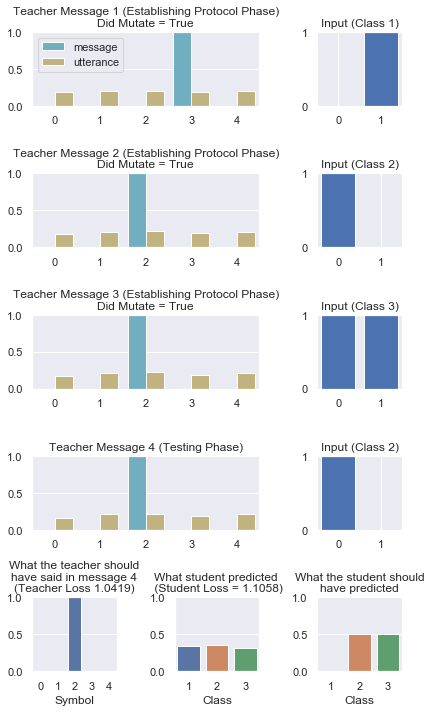

In [17]:
plot_game(inputs, outputs, targets, select_batch=6)

In [18]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 1.2496281862258911
agent/dense/bias:0 teacher grad norm: 1.1452168226242065
agent/lstm/kernel:0 teacher grad norm: 2.6698713302612305
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.3056151270866394
agent/lstm/bias:0 teacher grad norm: 2.1985507011413574
agent/dense_1/kernel:0 teacher grad norm: 1.1354612112045288
agent/dense_1/bias:0 teacher grad norm: 3.7078287601470947


# Run Experiments

In [19]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct,
        name='only_student_experiment'
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class,
        name='only_teacher_test_msg_experiment'
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o),
        name='only_teacher_create_protocol_experiment'
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn,
        name='other_play_experiment'
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        name='other_play_separate_optimise_experiment'
    )

def create_self_play_experiment(p_mutate=0.3, epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='self_play_experiment'
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=100, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    def loss_fn(o, t):
        return combined_loss_fn(o, t, w=0.5)
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=loss_fn,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_mut_temp_direct_loss_experiment(
    p_mutate=0.3, channel_size=5, epochs=250, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
#             'stop_gradients_on_final_message': True,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_message_permutation_experiment(epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='message_permutation_experiment'
    )

def create_message_permutation_is_all_you_need_experiment(epochs=100):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        name='message_permutation_is_all_you_need'
    )

In [23]:
mutation_temp_anneal_exp = create_mutation_with_temp_annealing_experiment()

In [23]:
mutation_temp_anneal_exp.max_epochs = 150

In [ ]:
mutation_temp_anneal_exp.run()

In [ ]:
msg_mut_exp = create_self_play_experiment()

In [ ]:
msg_mut_exp.run()

In [ ]:
exp = mutation_temp_anneal_exp
games_played, test_metrics = exp.run_tests()
test_metrics, exp.get_config()

In [ ]:
permutation_experiment = create_message_permutation_is_all_you_need_experiment(epochs=200)

In [ ]:
permutation_experiment.run()

In [ ]:
games_played, test_metrics = permutation_experiment.run_tests()

In [ ]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1, annot=True);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

In [ ]:
exp = mutation_temp_anneal_exp
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(exp.training_history)), 
             y=[item['loss'] for item in exp.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in exp.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * exp.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    if 'error' in metric:
        continue
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=metric,
                 ax=ax)

In [31]:
def protocol_entropy(outputs, beta=100):
    _, history = outputs
    messages = get_sent_messages(history)

    num_msgs, batch_size, channel_size = tf.shape(messages)

    # arrange protocol matrix columns into rows across 
    # all batches - will be reshaped back later
    protocol_msgs = messages[:-1, :, :]
    protocol_msgs = tf.einsum('ijk->jki', protocol_msgs)
    num_classes = protocol_msgs.shape[-1]
    new_shape = (batch_size*channel_size, num_classes)
    protocol_msgs = tf.reshape(protocol_msgs, new_shape)

    # normalise matrix columns - terminology is backwards because
    # tfp expects each row to be a distribution so the 
    # protocol matrix is transposed
    row_sums = tf.reduce_sum(protocol_msgs, axis=-1)
    row_sums = tf.reshape(row_sums, (tf.shape(row_sums)[0], 1))
    row_sums = tf.repeat(row_sums, num_classes, axis=-1)

    eps = 1e-15 # small value to avoid div by zero 
    probs = eps + protocol_msgs / (row_sums + eps)

    entropy = cce(probs, probs)
    entropy = tf.reshape(entropy, (batch_size, channel_size))
    entropy = tf.reduce_sum(entropy**beta, axis=-1)

    return entropy


def complete_loss_fn(outputs, targets, 
                     w1=1.0, w2=3.0, w3=1.0):
    loss = w1 * teacher_test_message_is_correct(outputs, targets)
#     loss = loss + protocol_diversity_loss(outputs)
    loss = loss + w2 * protocol_entropy(outputs)
    loss = loss + w3 * student_pred_matches_implied_class(outputs, targets)
    return loss

experiment = create_self_play_experiment(epochs=100, p_mutate=0.0)
experiment.get_config()

{'name': 'self_play_experiment',
 'max_epochs': 100,
 'steps_per_epoch': 50,
 'epochs_optimised': 0,
 'play_params': {'channel_size': 5, 'p_mutate': 0.0},
 'test_freq': 5,
 'test_steps': 25,
 'optimiser_config': {'name': 'RMSprop',
  'learning_rate': 0.01,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False},
 'optimise_agents_separately': False,
 'loss_fn': 'complete_loss_fn'}

In [32]:
experiment.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 100, 'steps_per_epoch': 50, 'epochs_optimised': 14, 'play_params': {'channel_size': 5, 'p_mutate': 0.0}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:6, Mean Loss: 407.495
Test Loss: 4.879, Ground Truth F1-Score: 0.314, Student Error: 1.132, Teacher Error: 3.748, Protocol Diversity: 0.5, Protocol Entropy: 0.16,
Epoch 1, Time Taken (mm:ss): 0:6, Mean Loss: 601.144
Epoch 2, Time Taken (mm:ss): 0:6, Mean Loss: 26.004
Epoch 3, Time Taken (mm:ss): 0:8, Mean Loss: 3.027
Epoch 4, Time Taken (mm:ss): 0:9, Mean Loss: 3.013
Epoch 5, Time Taken (mm:ss): 0:8, Mean Loss: 2.307
Test Loss: 1.815, Ground Truth F1-Score: 0.401, Student Error: 0.555, Teac

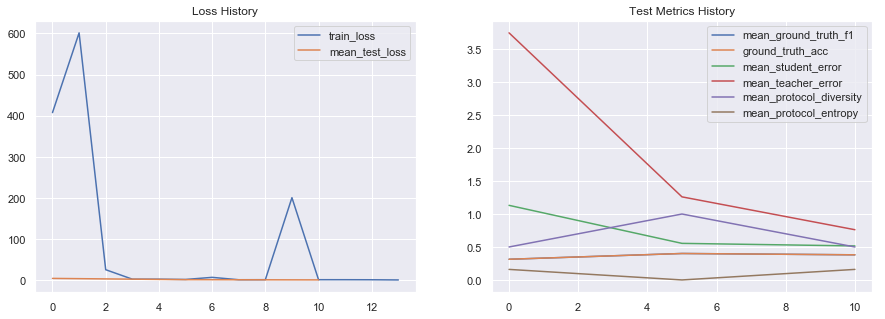

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in experiment.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * experiment.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=f'{metric}',
                 ax=ax)

In [86]:
history = [
    {'message_from_teacher': [
        [0., 0., 0., 0., 1.], [0., 1., 0., 0., 0.], [0., 0., 1., 0., 0.]
    ]},
    {'message_from_teacher': [
        [0., 0., 0., 0., 1.], [0., 0., 1., 0., 0.], [0., .1, .9, 0., 0.]
    ]},
    {'message_from_teacher': [
        [0., 0., 0., 0., 1.], [0., 0., 0., 1., 0.], [0., 0., 1., 0., 0.]
    ]},
    {'message_from_teacher': [
        [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.]
    ]},
]

In [30]:
tf.metrics.categorical_crossentropy([0.5, 0.5], [0.5, 0.5])**0.5

<tf.Tensor: shape=(), dtype=float32, numpy=0.83255464>

In [89]:
protocol_entropy((None, history))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.0986123e+00, 3.5762795e-07, 1.0974089e+00], dtype=float32)>

In [87]:
protocol_entropy(outputs)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123], dtype=float32)>

In [ ]:
tf.keras.losses.kullback_leibler_divergence()

In [ ]:
experiment2 = create_self_play_experiment()

In [ ]:
experiment2.run()

In [ ]:
axs = experiment.plot_training_history()
experiment2.plot_training_history(axs=axs)

## Render Model Graph in Tensorboard

In [2]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)

# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [3]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [24]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 0.47272029519081116,
 'mean_ground_truth_f1': 0.64625,
 'ground_truth_acc': 0.64625,
 'mean_student_error': 0.47222891449928284,
 'mean_teacher_error': 0.0004909178824163973,
 'mean_protocol_diversity': 0.5,
 'mean_protocol_entropy': 0.1600022315979004}

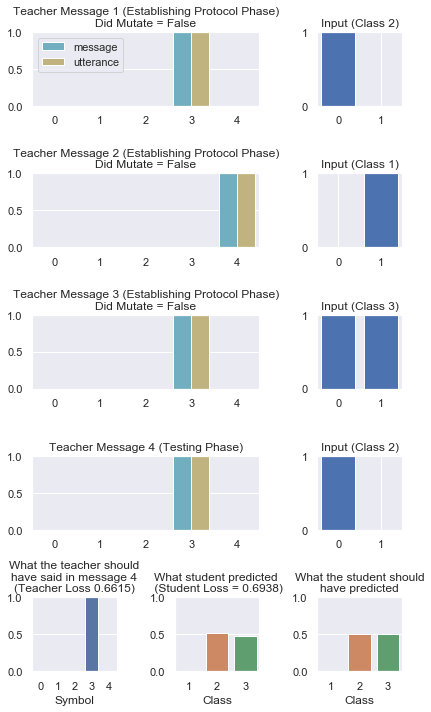

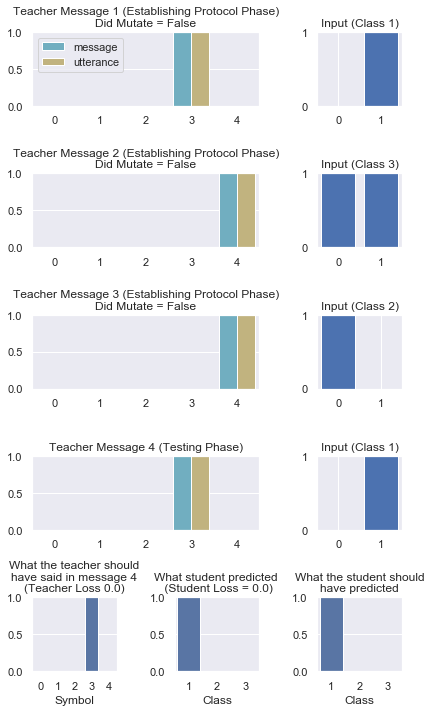

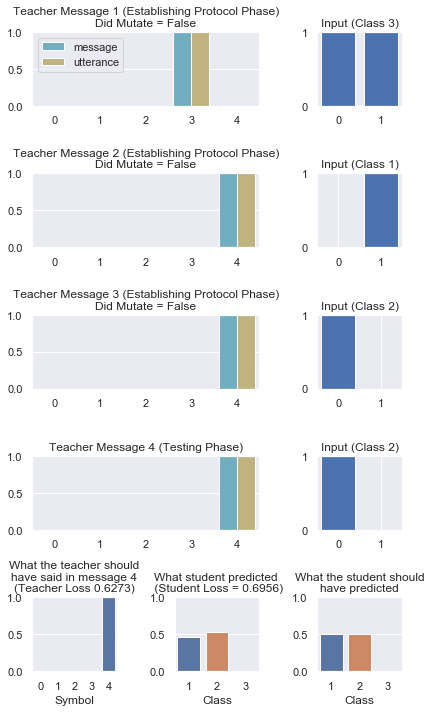

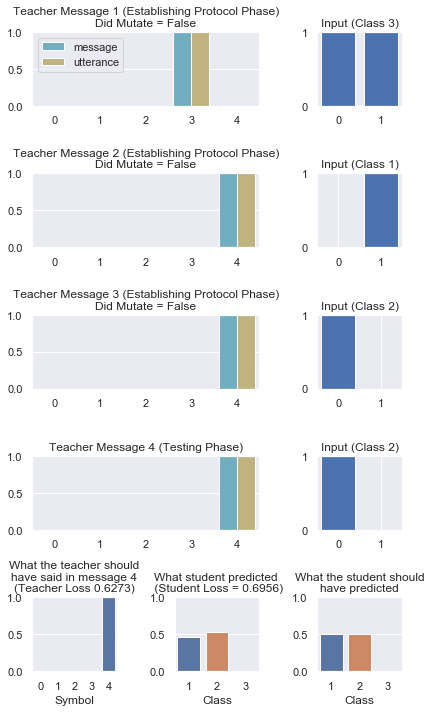

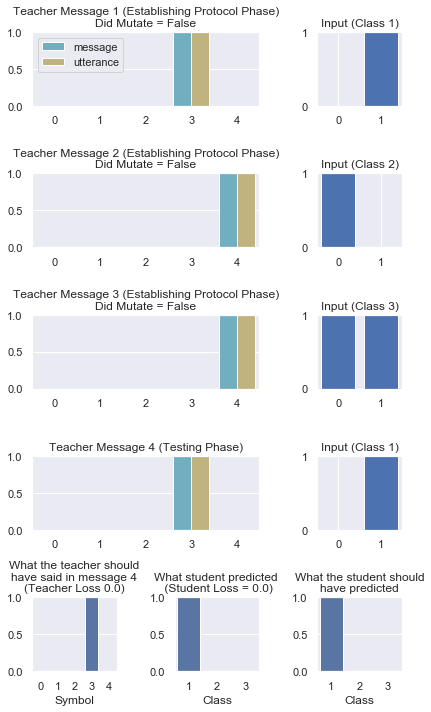

In [25]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

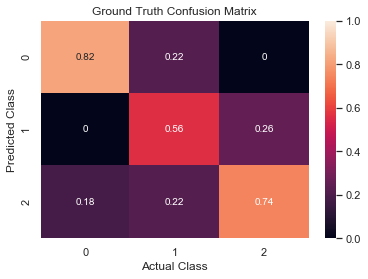

In [26]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

In [39]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

NameError: name 'experiment2' is not defined

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

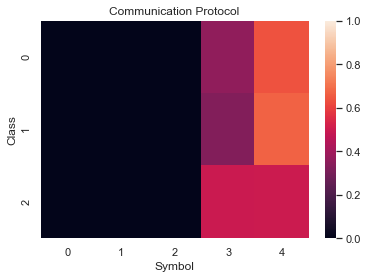

In [29]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

## Zero-shot Coordination

In [ ]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)

teacher_error, protocol_diversity = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Protocol Diversity {protocol_diversity}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

In [ ]:
plot_game(inputs, outputs, targets, select_batch=1)

In [ ]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)

teacher_error, protocol_diversity = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Protocol Diversity {protocol_diversity}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

In [ ]:
plot_game(inputs, outputs, targets)